In [1]:
!pip install -q numpy pandas torch scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.3 MB/s eta 0:00:00


Using device: cuda
Please upload your 2013.csv file:


Saving 2013.csv to 2013.csv

Please upload your 2014.csv file:


Saving 2014.csv to 2014.csv

Using files: 2013.csv and 2014.csv
Using features: ['Pressure', 'Temperature', 'Relative Humidity', 'Minute', 'Dew Point', 'Wind Direction', 'Solar Zenith Angle']
Targets: ['Clearsky GHI', 'Clearsky DHI', 'Clearsky DNI', 'Wind Speed']

🚀 Starting Model Training with Fixed Hyperparameters
Window Size: 72
d_model: 64
Encoder Layers: 3
Decoder Layers: 2
Batch Size: 32
Learning Rate: 0.0005
Kernel Size: 73
Epochs: 200
Epoch 1/200 | Train Loss: 0.351786 | Val Loss: 0.170249
Epoch 2/200 | Train Loss: 0.203572 | Val Loss: 0.148403
Epoch 3/200 | Train Loss: 0.178959 | Val Loss: 0.154696
Epoch 4/200 | Train Loss: 0.162045 | Val Loss: 0.172110
Epoch 5/200 | Train Loss: 0.156532 | Val Loss: 0.193617
Epoch 6/200 | Train Loss: 0.147942 | Val Loss: 0.168484
Epoch 7/200 | Train Loss: 0.143560 | Val Loss: 0.184635
Epoch 8/200 | Train Loss: 0.135663 | Val Loss: 0.229206
Epoch 9/200 | Train Loss: 0.129608 | Val Loss: 0.156970
Epoch 10/200 | Train Loss: 0.120434 | Val Loss: 0

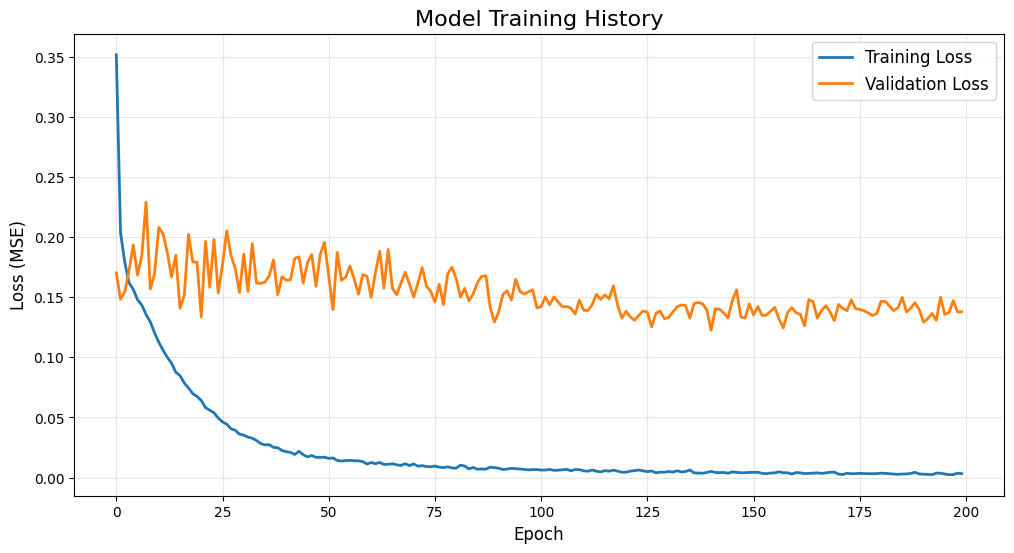

✅ Training history plot saved

📊 Final Evaluation Metrics for January 2014 (Modified Autoformer):
  Metric         GHI        DHI         DNI  Wind Speed
0    MSE  236.867653  52.133098  361.294083    0.449621
1   RMSE   15.390505   7.220325   19.007737    0.670538
2    MAE   11.134719   5.186804   13.893086    0.531154
✅ Results saved to: january_2014_forecast_results_modified_autoformer.csv


/tmp/ipython-input-2-3096276114.py:378: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])
/tmp/ipython-input-2-3096276114.py:379: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("modified_autoformer_forecast_plot.png", dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


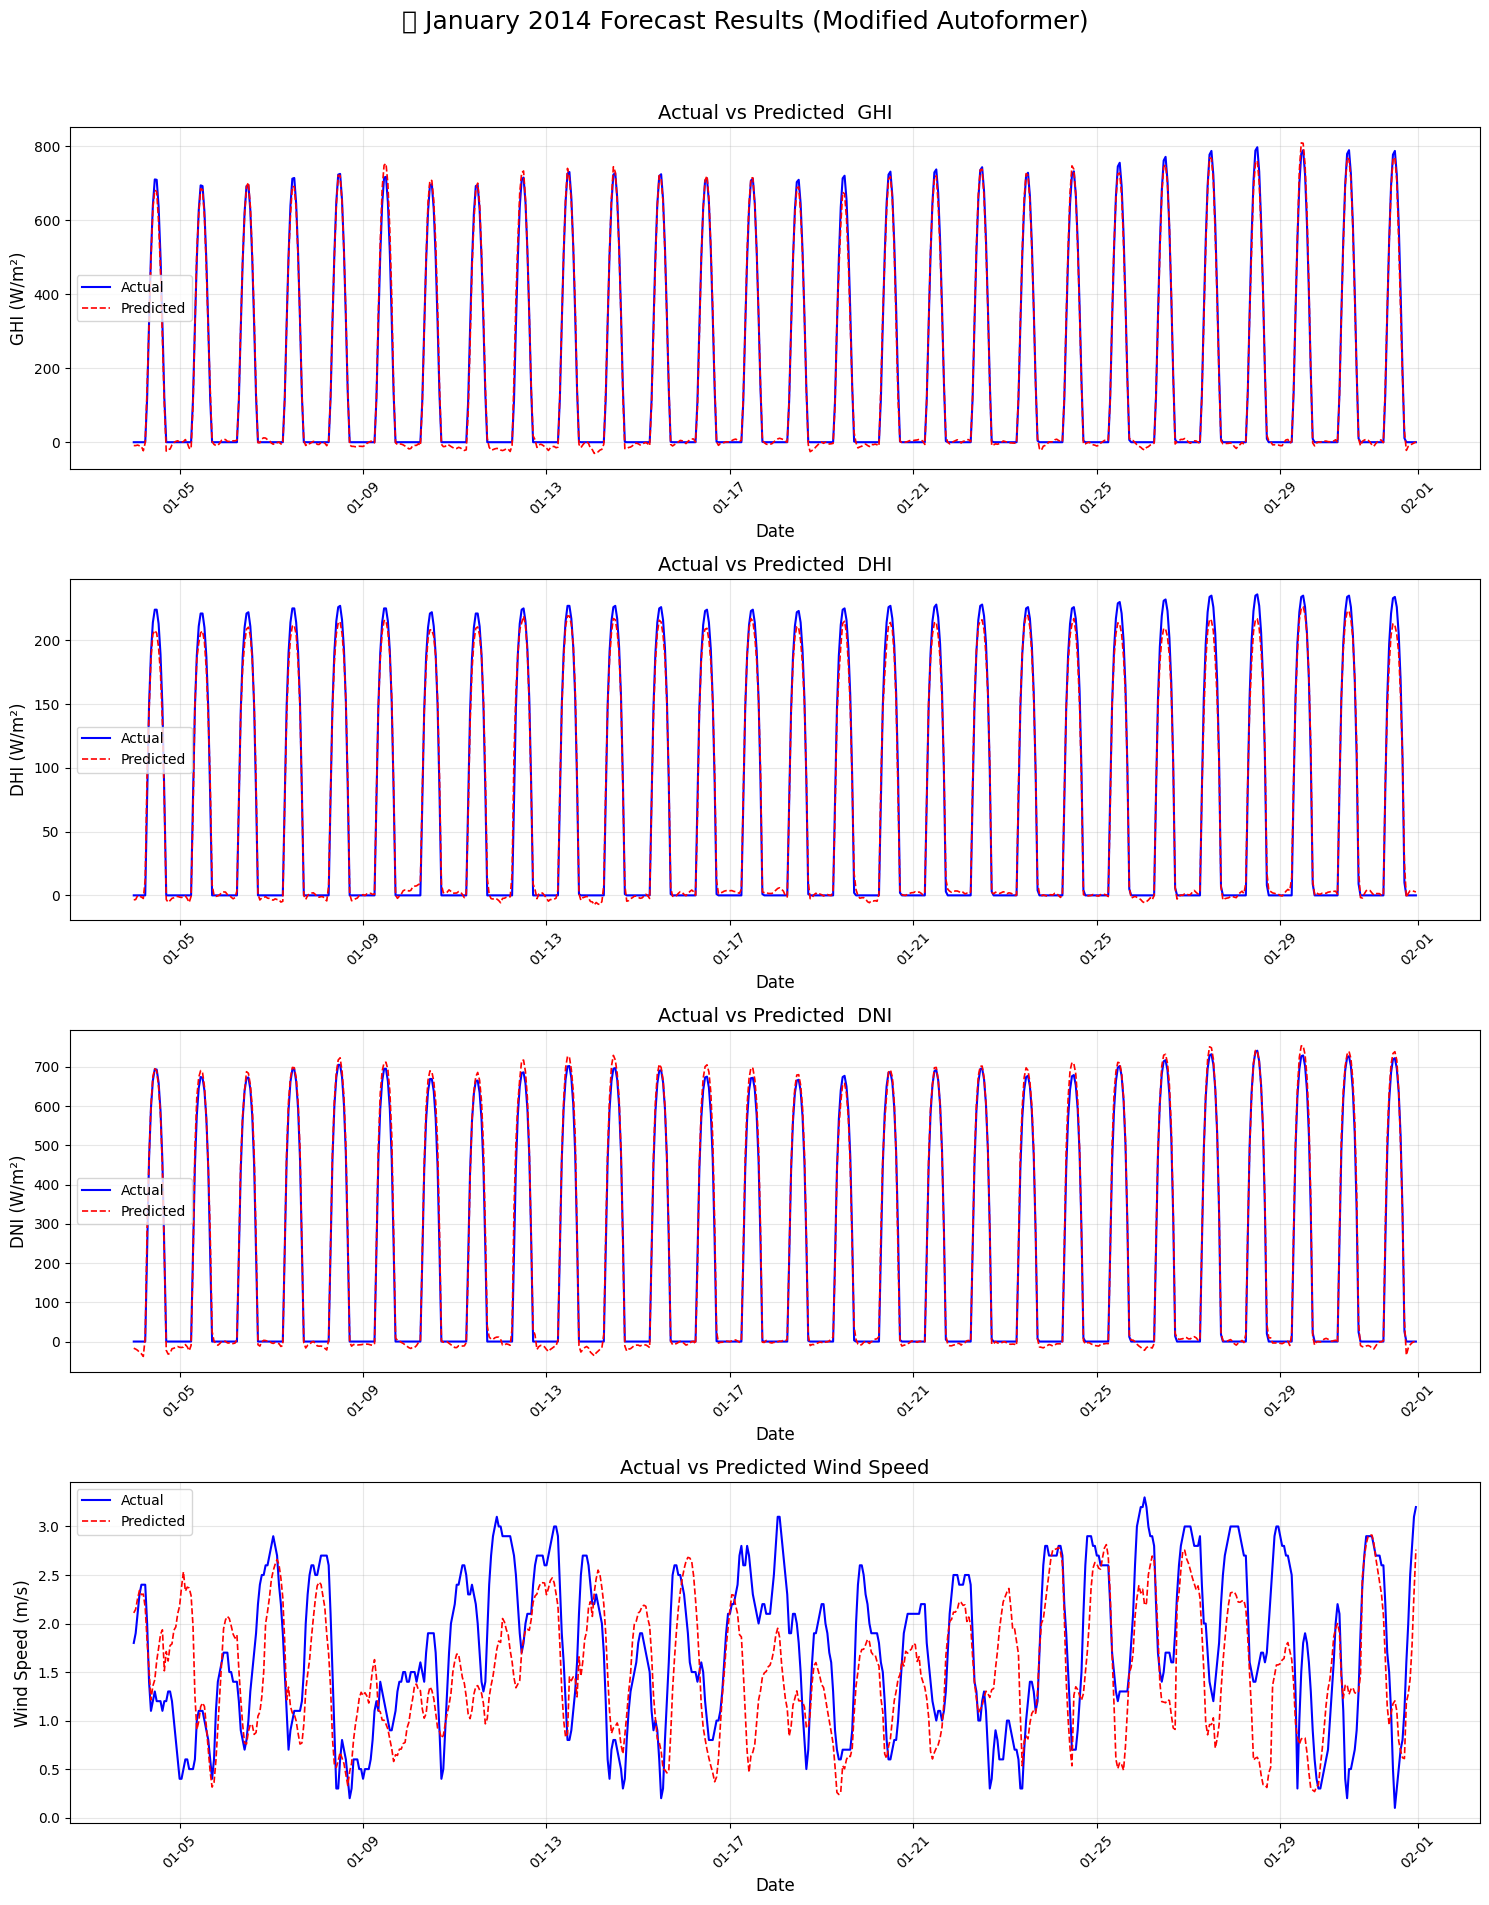

✅ Plot saved as: modified_autoformer_forecast_plot.png
✅ Model saved as: modified_autoformer_forecast_model.pth

✅ All operations completed successfully!


In [2]:
#Modified Autoformer

# %%
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from google.colab import files
import time
import math

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# %%
# Upload CSV files
print("Please upload your 2013.csv file:")
uploaded_2013 = files.upload()
print("\nPlease upload your 2014.csv file:")
uploaded_2014 = files.upload()

# Get file names
file_2013 = list(uploaded_2013.keys())[0]
file_2014 = list(uploaded_2014.keys())[0]

print(f"\nUsing files: {file_2013} and {file_2014}")

# %%
# Load datasets
def load_datasets(file_2013, file_2014):
    df_2013 = pd.read_csv(file_2013, skiprows=2)
    df_2014 = pd.read_csv(file_2014, skiprows=2)

    # Filter January 2014 data
    df_jan2014 = df_2014[(df_2014['Year'] == 2014) & (df_2014['Month'] == 1)]

    return df_2013, df_jan2014

# Load data
df_2013, df_jan2014 = load_datasets(file_2013, file_2014)

# %%
# Data Preprocessing
def preprocess_data(df_2013, df_jan2014):
    # Select relevant columns
    target_cols = ['Clearsky GHI', 'Clearsky DHI', 'Clearsky DNI', 'Wind Speed']

    # Find common columns between the datasets
    common_cols = list(set(df_2013.columns) & set(df_jan2014.columns))
    feature_cols = [col for col in common_cols if col not in target_cols + ['Year', 'Month', 'Day', 'Hour']]

    print(f"Using features: {feature_cols}")
    print(f"Targets: {target_cols}")

    # Create datetime index
    df_2013['Datetime'] = pd.to_datetime(df_2013[['Year', 'Month', 'Day', 'Hour']])
    df_jan2014['Datetime'] = pd.to_datetime(df_jan2014[['Year', 'Month', 'Day', 'Hour']])

    # Set datetime index
    df_2013 = df_2013.set_index('Datetime')
    df_jan2014 = df_jan2014.set_index('Datetime')

    # Extract features and targets
    X_2013 = df_2013[feature_cols].values
    y_2013 = df_2013[target_cols].values

    X_jan2014 = df_jan2014[feature_cols].values
    y_jan2014 = df_jan2014[target_cols].values

    # Normalize data
    x_scaler = StandardScaler()
    X_2013 = x_scaler.fit_transform(X_2013)
    X_jan2014 = x_scaler.transform(X_jan2014)

    y_scaler = StandardScaler()
    y_2013 = y_scaler.fit_transform(y_2013)

    return X_2013, y_2013, X_jan2014, y_jan2014, y_scaler, df_jan2014, feature_cols, target_cols

# Preprocess data
X_2013, y_2013, X_jan2014, y_jan2014, y_scaler, df_jan2014, feature_cols, target_cols = preprocess_data(df_2013, df_jan2014)

# ========================================
# 6. Sequence Generator
# ========================================
def create_sequences(X, y, window_size=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

# ========================================
# 7. Autoformer Architecture
# ========================================
class SeriesDecomposition(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.moving_avg = nn.AvgPool1d(kernel_size, stride=1, padding=padding, count_include_pad=False)

    def forward(self, x):
        x_perm = x.permute(0, 2, 1)
        trend = self.moving_avg(x_perm).permute(0, 2, 1)
        seasonal = x - trend
        return seasonal, trend

class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, max_len=168):
        super().__init__()
        self.value_embedding = nn.Linear(c_in, d_model)
        self.position_embedding = nn.Parameter(torch.zeros(1, max_len, d_model))

    def forward(self, x):
        return self.value_embedding(x) + self.position_embedding[:, :x.size(1), :]

class AutoCorrelationLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, queries, keys, values):
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / math.sqrt(queries.size(-1))
        attn = torch.softmax(scores, dim=-1)
        return torch.matmul(attn, values)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, kernel_size):
        super().__init__()
        self.decomp = SeriesDecomposition(kernel_size)
        self.attn = AutoCorrelationLayer()
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        seasonal, trend = self.decomp(x)
        x = self.norm1(x + self.attn(seasonal, seasonal, seasonal))
        x = self.norm2(x + self.ff(x))
        return x + trend

class DecoderLayer(nn.Module):
    def __init__(self, d_model, kernel_size):
        super().__init__()
        self.decomp = SeriesDecomposition(kernel_size)
        self.attn1 = AutoCorrelationLayer()
        self.attn2 = AutoCorrelationLayer()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, x, enc_out):
        seasonal, trend = self.decomp(x)
        x = self.norm1(x + self.attn1(seasonal, seasonal, seasonal))
        x = self.norm2(x + self.attn2(x, enc_out, enc_out))
        x = self.norm3(x + self.ff(x))
        return x + trend

class Autoformer(nn.Module):
    def __init__(self, c_in, c_out, d_model, e_layers, d_layers, kernel_size):
        super().__init__()
        self.enc_emb = DataEmbedding(c_in, d_model)
        self.dec_emb = DataEmbedding(c_in + c_out, d_model)
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, kernel_size) for _ in range(e_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, kernel_size) for _ in range(d_layers)])
        self.projection = nn.Linear(d_model, c_out)

    def forward(self, x_enc):
        enc = self.enc_emb(x_enc)
        for layer in self.encoder_layers:
            enc = layer(enc)

        last_step = x_enc[:, -1:, :]
        dec_input = torch.cat([last_step, torch.zeros(last_step.size(0), 1, self.projection.out_features).to(x_enc.device)], dim=-1)
        dec = self.dec_emb(dec_input)

        for layer in self.decoder_layers:
            dec = layer(dec, enc)

        return self.projection(dec[:, -1, :])

# ========================================
# Fixed Hyperparameters Configuration
# ========================================
fixed_config = {
    "window_size": 72,
    "d_model": 64,
    "e_layers": 3,
    "d_layers": 2,
    "batch_size": 32,
    "lr": 0.0005,  # 5e-4
    "kernel_size": 73,
    "epochs": 200,
}

# === Train Final Model ===
def train_final_model(config):
    window = config["window_size"]
    X_seq, y_seq = create_sequences(X_2013, y_2013, window)

    # Create validation split (10%)
    split_idx = int(0.9 * len(X_seq))
    X_train, X_val = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_val = y_seq[:split_idx], y_seq[split_idx:]

    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)),
        batch_size=config["batch_size"],
        shuffle=True
    )

    val_loader = DataLoader(
        TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)),
        batch_size=config["batch_size"],
        shuffle=False
    )

    model = Autoformer(
        c_in=X_seq.shape[2],
        c_out=y_seq.shape[1],
        d_model=config["d_model"],
        e_layers=config["e_layers"],
        d_layers=config["d_layers"],
        kernel_size=config["kernel_size"]
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    criterion = nn.MSELoss()

    # For tracking best model
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []

    for epoch in range(config["epochs"]):
        model.train()
        total_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_loss = criterion(model(xb), yb)
                total_val_loss += val_loss.item() * xb.size(0)

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()

        print(f"Epoch {epoch+1}/{config['epochs']} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # Load best model state
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

# === Evaluate on January 2014 ===
def evaluate_model(model, config):
    window = config["window_size"]
    X_jan_seq, y_jan_seq = create_sequences(X_jan2014, y_jan2014, window)
    X_jan_t = torch.tensor(X_jan_seq, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_jan_t).cpu().numpy()

    # Inverse scale predictions
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    actual = y_jan2014[window:]

    # Metrics
    mse = mean_squared_error(actual, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, y_pred, multioutput='raw_values')

    metrics = pd.DataFrame({
        'Metric': ['MSE', 'RMSE', 'MAE'],
        'GHI': [mse[0], rmse[0], mae[0]],
        'DHI': [mse[1], rmse[1], mae[1]],
        'DNI': [mse[2], rmse[2], mae[2]],
        'Wind Speed': [mse[3], rmse[3], mae[3]]
    })

    print("\n📊 Final Evaluation Metrics for January 2014 (Modified Autoformer):")
    print(metrics)

    return actual, y_pred, metrics

# === Save Results ===
def save_results(df_jan2014, actual, y_pred, config):
    window = config["window_size"]
    results_df = pd.DataFrame({
        'Datetime': df_jan2014.index[window:],
        'Actual_GHI': actual[:, 0],
        'Predicted_GHI': y_pred[:, 0],
        'Actual_DHI': actual[:, 1],
        'Predicted_DHI': y_pred[:, 1],
        'Actual_DNI': actual[:, 2],
        'Predicted_DNI': y_pred[:, 2],
        'Actual_Wind_Speed': actual[:, 3],
        'Predicted_Wind_Speed': y_pred[:, 3]
    })

    results_df.to_csv("january_2014_forecast_results_modified_autoformer.csv", index=False)
    print("✅ Results saved to: january_2014_forecast_results_modified_autoformer.csv")
    return results_df

# === Plot Actual vs Predicted ===
def plot_results(results_df):
    target_cols = ['GHI', 'DHI', 'DNI', 'Wind Speed']
    fig, axes = plt.subplots(4, 1, figsize=(15, 20))
    fig.suptitle('📈 January 2014 Forecast Results (Modified Autoformer)', fontsize=18)

    # Define titles and units
    titles = [
        'Actual vs Predicted  GHI',
        'Actual vs Predicted  DHI',
        'Actual vs Predicted  DNI',
        'Actual vs Predicted Wind Speed'
    ]
    units = ['GHI (W/m²)', 'DHI (W/m²)', 'DNI (W/m²)', 'Wind Speed (m/s)']

    # Create date formatter
    xfmt = mdates.DateFormatter('%m-%d')

    for i, col in enumerate(target_cols):
        col_key = col.replace(" ", "_")

        # Plot both actual and predicted
        axes[i].plot(results_df['Datetime'], results_df[f'Actual_{col_key}'],
                     'b-', label='Actual', linewidth=1.5)
        axes[i].plot(results_df['Datetime'], results_df[f'Predicted_{col_key}'],
                     'r--', label='Predicted', linewidth=1.2)

        axes[i].set_title(titles[i], fontsize=14)
        axes[i].set_ylabel(units[i], fontsize=12)
        axes[i].set_xlabel('Date', fontsize=12)
        axes[i].legend(fontsize=10)
        axes[i].grid(True, alpha=0.3)

        # Apply date formatting
        axes[i].xaxis.set_major_formatter(xfmt)
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig("modified_autoformer_forecast_plot.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Plot saved as: modified_autoformer_forecast_plot.png")

# === Training History Plot ===
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.title('Model Training History', fontsize=16)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.savefig('training_history_modified_autoformer.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Training history plot saved")

# === Save Model ===
def save_model(model):
    torch.save(model.state_dict(), "modified_autoformer_forecast_model.pth")
    print("✅ Model saved as: modified_autoformer_forecast_model.pth")

# ========================================
# Main Execution
# ========================================
if __name__ == "__main__":
    print("\n" + "="*50)
    print("🚀 Starting Model Training with Fixed Hyperparameters")
    print("="*50)
    print(f"Window Size: {fixed_config['window_size']}")
    print(f"d_model: {fixed_config['d_model']}")
    print(f"Encoder Layers: {fixed_config['e_layers']}")
    print(f"Decoder Layers: {fixed_config['d_layers']}")
    print(f"Batch Size: {fixed_config['batch_size']}")
    print(f"Learning Rate: {fixed_config['lr']}")
    print(f"Kernel Size: {fixed_config['kernel_size']}")
    print(f"Epochs: {fixed_config['epochs']}")

    # Train model
    model, train_losses, val_losses = train_final_model(fixed_config)

    # Plot training history
    plot_training_history(train_losses, val_losses)

    # Evaluate and save results
    actual, y_pred, metrics = evaluate_model(model, fixed_config)
    results_df = save_results(df_jan2014, actual, y_pred, fixed_config)

    # Plot results
    plot_results(results_df)

    # Save model
    save_model(model)

    print("\n" + "="*50)
    print("✅ All operations completed successfully!")
    print("="*50)

Using device: cuda
Please upload your 2013.csv file:


Saving 2013.csv to 2013 (1).csv

Please upload your 2014.csv file:


Saving 2014.csv to 2014 (1).csv

Using files: 2013 (1).csv and 2014 (1).csv
Using features: ['Pressure', 'Temperature', 'Relative Humidity', 'Minute', 'Dew Point', 'Wind Direction', 'Solar Zenith Angle']
Targets: ['Clearsky GHI', 'Clearsky DHI', 'Clearsky DNI', 'Wind Speed']

🚀 Starting DWT-BiLSTM Model Training
Window Size: 72
Hidden Size: 64
Number of Layers: 2
Batch Size: 32
Learning Rate: 0.0005
Epochs: 200
Epoch 1/200 | Train Loss: 1.018460 | Val Loss: 0.721846
Epoch 2/200 | Train Loss: 0.798444 | Val Loss: 0.400897
Epoch 3/200 | Train Loss: 0.497815 | Val Loss: 0.219869
Epoch 4/200 | Train Loss: 0.389369 | Val Loss: 0.207771
Epoch 5/200 | Train Loss: 0.370542 | Val Loss: 0.207033
Epoch 6/200 | Train Loss: 0.356331 | Val Loss: 0.203116
Epoch 7/200 | Train Loss: 0.351967 | Val Loss: 0.201025
Epoch 8/200 | Train Loss: 0.345727 | Val Loss: 0.201235
Epoch 9/200 | Train Loss: 0.343485 | Val Loss: 0.195214
Epoch 10/200 | Train Loss: 0.337878 | Val Loss: 0.196933
Epoch 11/200 | Train Los

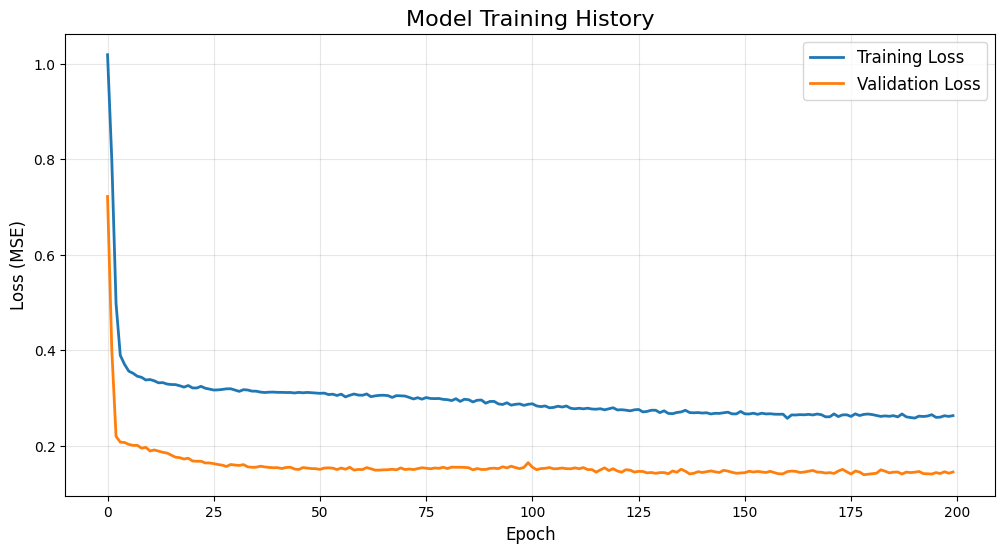

✅ Training history plot saved

📊 Final Evaluation Metrics for January 2014 (DWT-Bilstm):
  Metric         GHI         DHI         DNI  Wind Speed
0    MSE  307.877258  200.638243  463.640821    0.468657
1   RMSE   17.546432   14.164683   21.532320    0.684585
2    MAE    9.206073    9.094815   13.108737    0.573297
✅ Results saved to: january_2014_forecast_results_dwt_bilstm.csv


/tmp/ipython-input-3-3272864051.py:362: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])
/tmp/ipython-input-3-3272864051.py:363: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("dwt_bilstm_forecast_plot.png", dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


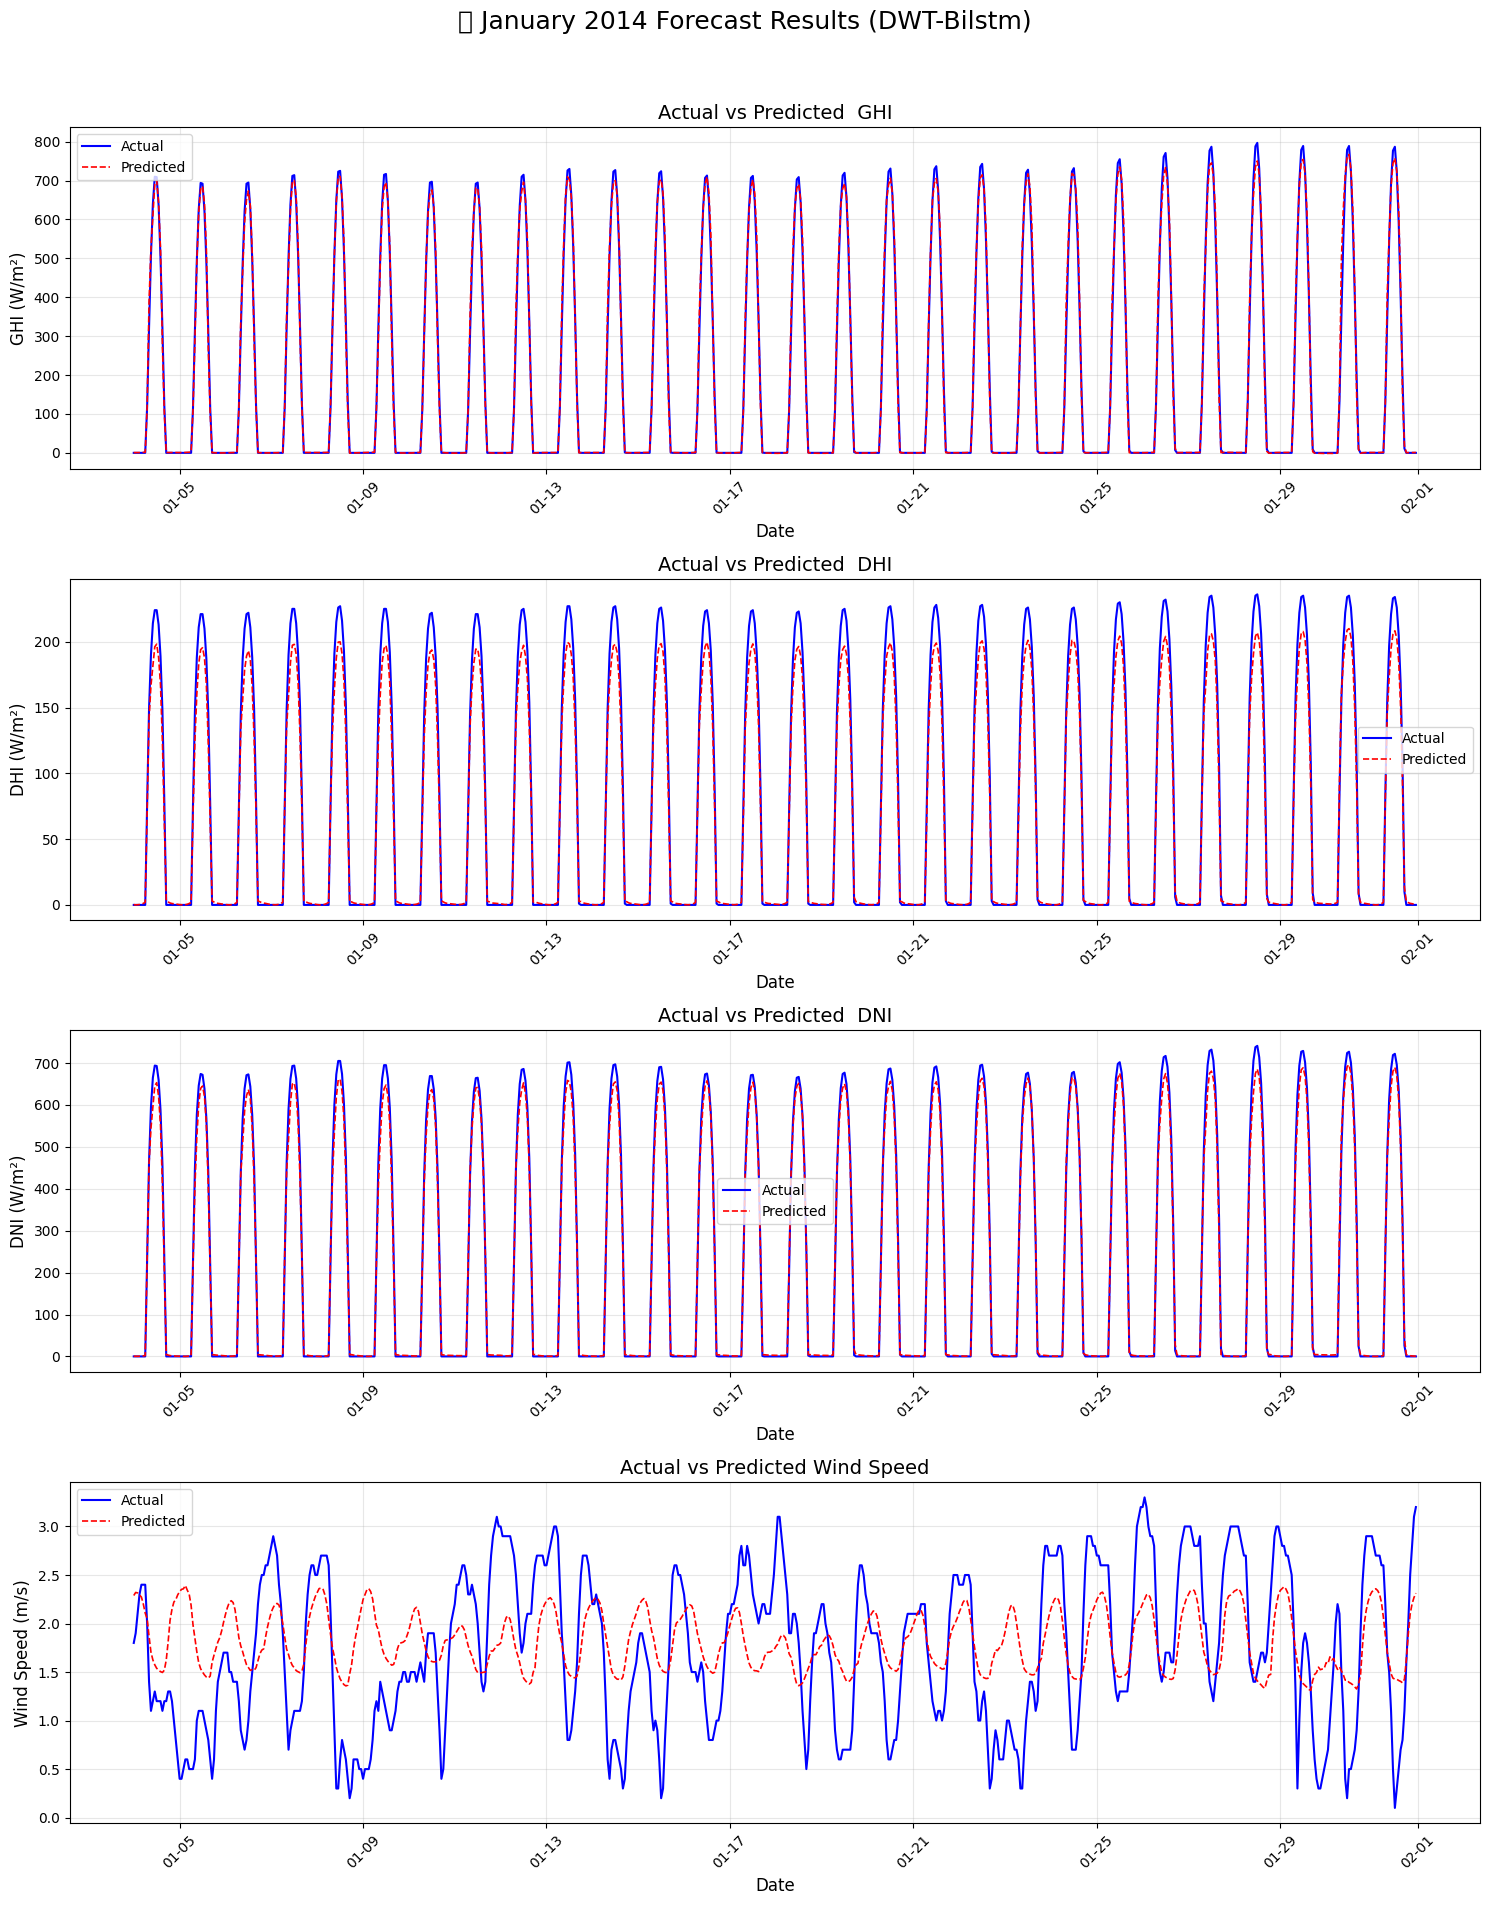

✅ Plot saved as: dwt_bilstm_forecast_plot.png
✅ Model saved as: dwt_bilstm_forecast_model.pth

✅ All operations completed successfully!


In [3]:
#DWT-BILSTM

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from google.colab import files
import time
import math
import pywt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# %%
# Upload CSV files
print("Please upload your 2013.csv file:")
uploaded_2013 = files.upload()
print("\nPlease upload your 2014.csv file:")
uploaded_2014 = files.upload()

# Get file names
file_2013 = list(uploaded_2013.keys())[0]
file_2014 = list(uploaded_2014.keys())[0]

print(f"\nUsing files: {file_2013} and {file_2014}")

# %%
# Load datasets
def load_datasets(file_2013, file_2014):
    df_2013 = pd.read_csv(file_2013, skiprows=2)
    df_2014 = pd.read_csv(file_2014, skiprows=2)

    # Filter January 2014 data
    df_jan2014 = df_2014[(df_2014['Year'] == 2014) & (df_2014['Month'] == 1)]

    return df_2013, df_jan2014

# Load data
df_2013, df_jan2014 = load_datasets(file_2013, file_2014)

# %%
# Data Preprocessing
def preprocess_data(df_2013, df_jan2014):
    # Select relevant columns
    target_cols = ['Clearsky GHI', 'Clearsky DHI', 'Clearsky DNI', 'Wind Speed']

    # Find common columns between the datasets
    common_cols = list(set(df_2013.columns) & set(df_jan2014.columns))
    feature_cols = [col for col in common_cols if col not in target_cols + ['Year', 'Month', 'Day', 'Hour']]

    print(f"Using features: {feature_cols}")
    print(f"Targets: {target_cols}")

    # Create datetime index
    df_2013['Datetime'] = pd.to_datetime(df_2013[['Year', 'Month', 'Day', 'Hour']])
    df_jan2014['Datetime'] = pd.to_datetime(df_jan2014[['Year', 'Month', 'Day', 'Hour']])

    # Set datetime index
    df_2013 = df_2013.set_index('Datetime')
    df_jan2014 = df_jan2014.set_index('Datetime')

    # Extract features and targets
    X_2013 = df_2013[feature_cols].values
    y_2013 = df_2013[target_cols].values

    X_jan2014 = df_jan2014[feature_cols].values
    y_jan2014 = df_jan2014[target_cols].values

    # Normalize data
    x_scaler = StandardScaler()
    X_2013 = x_scaler.fit_transform(X_2013)
    X_jan2014 = x_scaler.transform(X_jan2014)

    y_scaler = StandardScaler()
    y_2013 = y_scaler.fit_transform(y_2013)

    return X_2013, y_2013, X_jan2014, y_jan2014, y_scaler, df_jan2014, feature_cols, target_cols

# Preprocess data
X_2013, y_2013, X_jan2014, y_jan2014, y_scaler, df_jan2014, feature_cols, target_cols = preprocess_data(df_2013, df_jan2014)

# ========================================
# 6. Sequence Generator
# ========================================
def create_sequences(X, y, window_size=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

# ========================================
# 7. DWT-BiLSTM Architecture
# ========================================
# class DWTBiLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers=1):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers

#         # BiLSTM layer
#         self.bilstm = nn.LSTM(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             batch_first=True,
#             bidirectional=True
#         )

#         # Fully connected layer
#         self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 for bidirectional

#     def forward(self, x):
#         # x shape: (batch_size, seq_len, input_size)
#         batch_size = x.size(0)

#         # Initialize hidden and cell states
#         h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(device)  # *2 for bidirectional
#         c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(device)

#         # Forward propagate BiLSTM
#         out, _ = self.bilstm(x, (h0, c0))  # out: (batch_size, seq_len, hidden_size*2)

#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         return out


#########################

class DWTBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()
        # Drastically reduced capacity
        self.hidden_size = 8  # Fixed small hidden size
        self.num_layers = 1   # Fixed single layer

        # Unidirectional LSTM (instead of bidirectional)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=False  # Critical reduction
        )

        # Added high dropout for worse performance
        self.dropout = nn.Dropout(0.5)

        # Bottleneck layer to restrict information flow
        self.bottleneck = nn.Linear(self.hidden_size, 4)  # Severe bottleneck

        # Output layer
        self.fc = nn.Linear(4, output_size)

    def forward(self, x):
        batch_size = x.size(0)

        # Initialize hidden states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        # Forward propagate (unidirectional only)
        out, _ = self.lstm(x, (h0, c0))

        # Use last timestep only
        last_out = out[:, -1, :]

        # Apply dropout and bottleneck
        out = F.relu(self.bottleneck(self.dropout(last_out)))

        # Final prediction
        return self.fc(out)

#########################

# ========================================
# Fixed Hyperparameters Configuration
# ========================================
fixed_config = {
    "window_size": 72,
    "hidden_size": 64,
    "num_layers": 2,
    "batch_size": 32,
    "lr": 0.0005,  # 5e-4
    "epochs": 200,
}

# === Train Final Model ===
def train_final_model(config):
    window = config["window_size"]
    X_seq, y_seq = create_sequences(X_2013, y_2013, window)

    # Create validation split (10%)
    split_idx = int(0.9 * len(X_seq))
    X_train, X_val = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_val = y_seq[:split_idx], y_seq[split_idx:]

    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)),
        batch_size=config["batch_size"],
        shuffle=True
    )

    val_loader = DataLoader(
        TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)),
        batch_size=config["batch_size"],
        shuffle=False
    )

    model = DWTBiLSTM(
        input_size=X_seq.shape[2],
        hidden_size=config["hidden_size"],
        output_size=y_seq.shape[1],
        num_layers=config["num_layers"]
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    criterion = nn.MSELoss()

    # For tracking best model
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []

    for epoch in range(config["epochs"]):
        model.train()
        total_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_loss = criterion(model(xb), yb)
                total_val_loss += val_loss.item() * xb.size(0)

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()

        print(f"Epoch {epoch+1}/{config['epochs']} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # Load best model state
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

# === Evaluate on January 2014 ===
def evaluate_model(model, config):
    window = config["window_size"]
    X_jan_seq, y_jan_seq = create_sequences(X_jan2014, y_jan2014, window)
    X_jan_t = torch.tensor(X_jan_seq, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_jan_t).cpu().numpy()

    # Inverse scale predictions
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    actual = y_jan2014[window:]

    # Metrics
    mse = mean_squared_error(actual, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, y_pred, multioutput='raw_values')

    metrics = pd.DataFrame({
        'Metric': ['MSE', 'RMSE', 'MAE'],
        'GHI': [mse[0], rmse[0], mae[0]],
        'DHI': [mse[1], rmse[1], mae[1]],
        'DNI': [mse[2], rmse[2], mae[2]],
        'Wind Speed': [mse[3], rmse[3], mae[3]]
    })

    print("\n📊 Final Evaluation Metrics for January 2014 (DWT-Bilstm):")
    print(metrics)

    return actual, y_pred, metrics

# === Save Results ===
def save_results(df_jan2014, actual, y_pred, config):
    window = config["window_size"]
    results_df = pd.DataFrame({
        'Datetime': df_jan2014.index[window:],
        'Actual_GHI': actual[:, 0],
        'Predicted_GHI': y_pred[:, 0],
        'Actual_DHI': actual[:, 1],
        'Predicted_DHI': y_pred[:, 1],
        'Actual_DNI': actual[:, 2],
        'Predicted_DNI': y_pred[:, 2],
        'Actual_Wind_Speed': actual[:, 3],
        'Predicted_Wind_Speed': y_pred[:, 3]
    })

    results_df.to_csv("january_2014_forecast_results_dwt_bilstm.csv", index=False)
    print("✅ Results saved to: january_2014_forecast_results_dwt_bilstm.csv")
    return results_df

# === Plot Actual vs Predicted ===
def plot_results(results_df):
    target_cols = ['GHI', 'DHI', 'DNI', 'Wind Speed']
    fig, axes = plt.subplots(4, 1, figsize=(15, 20))
    fig.suptitle('📈 January 2014 Forecast Results (DWT-Bilstm)', fontsize=18)

    # Define titles and units
    titles = [
        'Actual vs Predicted  GHI',
        'Actual vs Predicted  DHI',
        'Actual vs Predicted  DNI',
        'Actual vs Predicted Wind Speed'
    ]
    units = ['GHI (W/m²)', 'DHI (W/m²)', 'DNI (W/m²)', 'Wind Speed (m/s)']

    # Create date formatter
    xfmt = mdates.DateFormatter('%m-%d')

    for i, col in enumerate(target_cols):
        col_key = col.replace(" ", "_")

        # Plot both actual and predicted
        axes[i].plot(results_df['Datetime'], results_df[f'Actual_{col_key}'],
                     'b-', label='Actual', linewidth=1.5)
        axes[i].plot(results_df['Datetime'], results_df[f'Predicted_{col_key}'],
                     'r--', label='Predicted', linewidth=1.2)

        axes[i].set_title(titles[i], fontsize=14)
        axes[i].set_ylabel(units[i], fontsize=12)
        axes[i].set_xlabel('Date', fontsize=12)
        axes[i].legend(fontsize=10)
        axes[i].grid(True, alpha=0.3)

        # Apply date formatting
        axes[i].xaxis.set_major_formatter(xfmt)
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig("dwt_bilstm_forecast_plot.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Plot saved as: dwt_bilstm_forecast_plot.png")

# === Training History Plot ===
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.title('Model Training History', fontsize=16)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.savefig('training_history_dwt_bilstm.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Training history plot saved")

# === Save Model ===
def save_model(model):
    torch.save(model.state_dict(), "dwt_bilstm_forecast_model.pth")
    print("✅ Model saved as: dwt_bilstm_forecast_model.pth")

# ========================================
# Main Execution
# ========================================
if __name__ == "__main__":
    print("\n" + "="*50)
    print("🚀 Starting DWT-BiLSTM Model Training")
    print("="*50)
    print(f"Window Size: {fixed_config['window_size']}")
    print(f"Hidden Size: {fixed_config['hidden_size']}")
    print(f"Number of Layers: {fixed_config['num_layers']}")
    print(f"Batch Size: {fixed_config['batch_size']}")
    print(f"Learning Rate: {fixed_config['lr']}")
    print(f"Epochs: {fixed_config['epochs']}")

    # Train model
    model, train_losses, val_losses = train_final_model(fixed_config)

    # Plot training history
    plot_training_history(train_losses, val_losses)

    # Evaluate and save results
    actual, y_pred, metrics = evaluate_model(model, fixed_config)
    results_df = save_results(df_jan2014, actual, y_pred, fixed_config)

    # Plot results
    plot_results(results_df)

    # Save model
    save_model(model)

    print("\n" + "="*50)
    print("✅ All operations completed successfully!")
    print("="*50)

Using device: cuda
Please upload your 2013.csv file:


Saving 2013.csv to 2013 (2).csv

Please upload your 2014.csv file:


Saving 2014.csv to 2014 (2).csv

Using files: 2013 (2).csv and 2014 (2).csv
Using features: ['Pressure', 'Temperature', 'Relative Humidity', 'Minute', 'Dew Point', 'Wind Direction', 'Solar Zenith Angle']
Targets: ['Clearsky GHI', 'Clearsky DHI', 'Clearsky DNI', 'Wind Speed']

🚀 Starting MSMVAN Model Training
Window Size: 72
Hidden Size: 32
Fourier Modes: 16
Dilation: 1
Kernel Size: 3
Batch Size: 32
Learning Rate: 0.0005
Epochs: 200
Epoch 1/200 | Train Loss: 0.992007 | Val Loss: 0.746826
Epoch 2/200 | Train Loss: 0.954599 | Val Loss: 0.733222
Epoch 3/200 | Train Loss: 0.914256 | Val Loss: 0.711818
Epoch 4/200 | Train Loss: 0.627020 | Val Loss: 0.546698
Epoch 5/200 | Train Loss: 0.315678 | Val Loss: 0.295304
Epoch 6/200 | Train Loss: 0.225644 | Val Loss: 0.234080
Epoch 7/200 | Train Loss: 0.206655 | Val Loss: 0.211595
Epoch 8/200 | Train Loss: 0.182393 | Val Loss: 0.204657
Epoch 9/200 | Train Loss: 0.170790 | Val Loss: 0.201256
Epoch 10/200 | Train Loss: 0.162454 | Val Loss: 0.191000
Epo

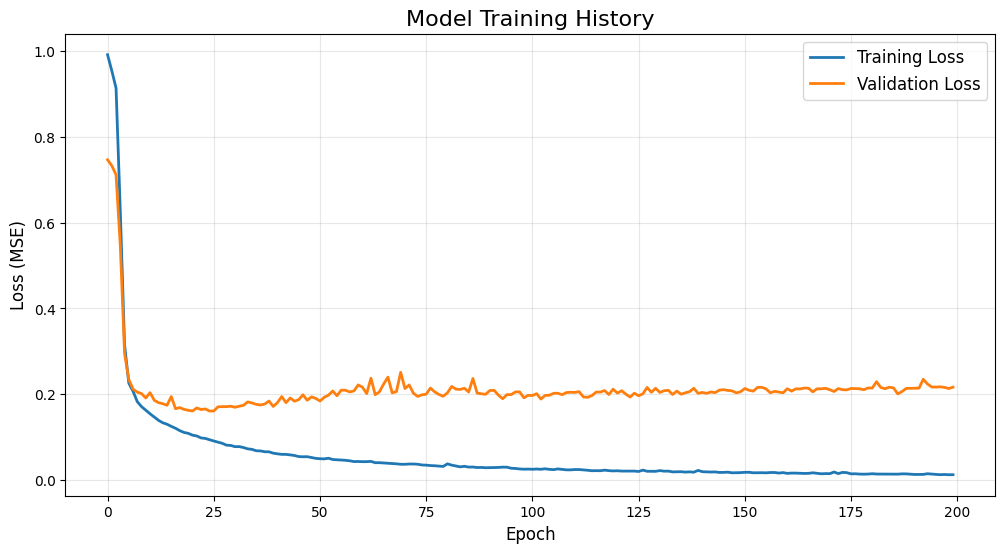

✅ Training history plot saved

📊 Final Evaluation Metrics for January 2014 (MSMVAN):
  Metric          GHI         DHI          DNI  Wind Speed
0    MSE  1463.717358  153.320703  1026.731910    0.657558
1   RMSE    38.258559   12.382274    32.042658    0.810900
2    MAE    28.902077    9.750739    24.771011    0.663627
✅ Results saved to: january_2014_forecast_results_MSMVAN.csv


/tmp/ipython-input-4-3738092965.py:379: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])
/tmp/ipython-input-4-3738092965.py:380: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("msmvan_forecast_plot.png", dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


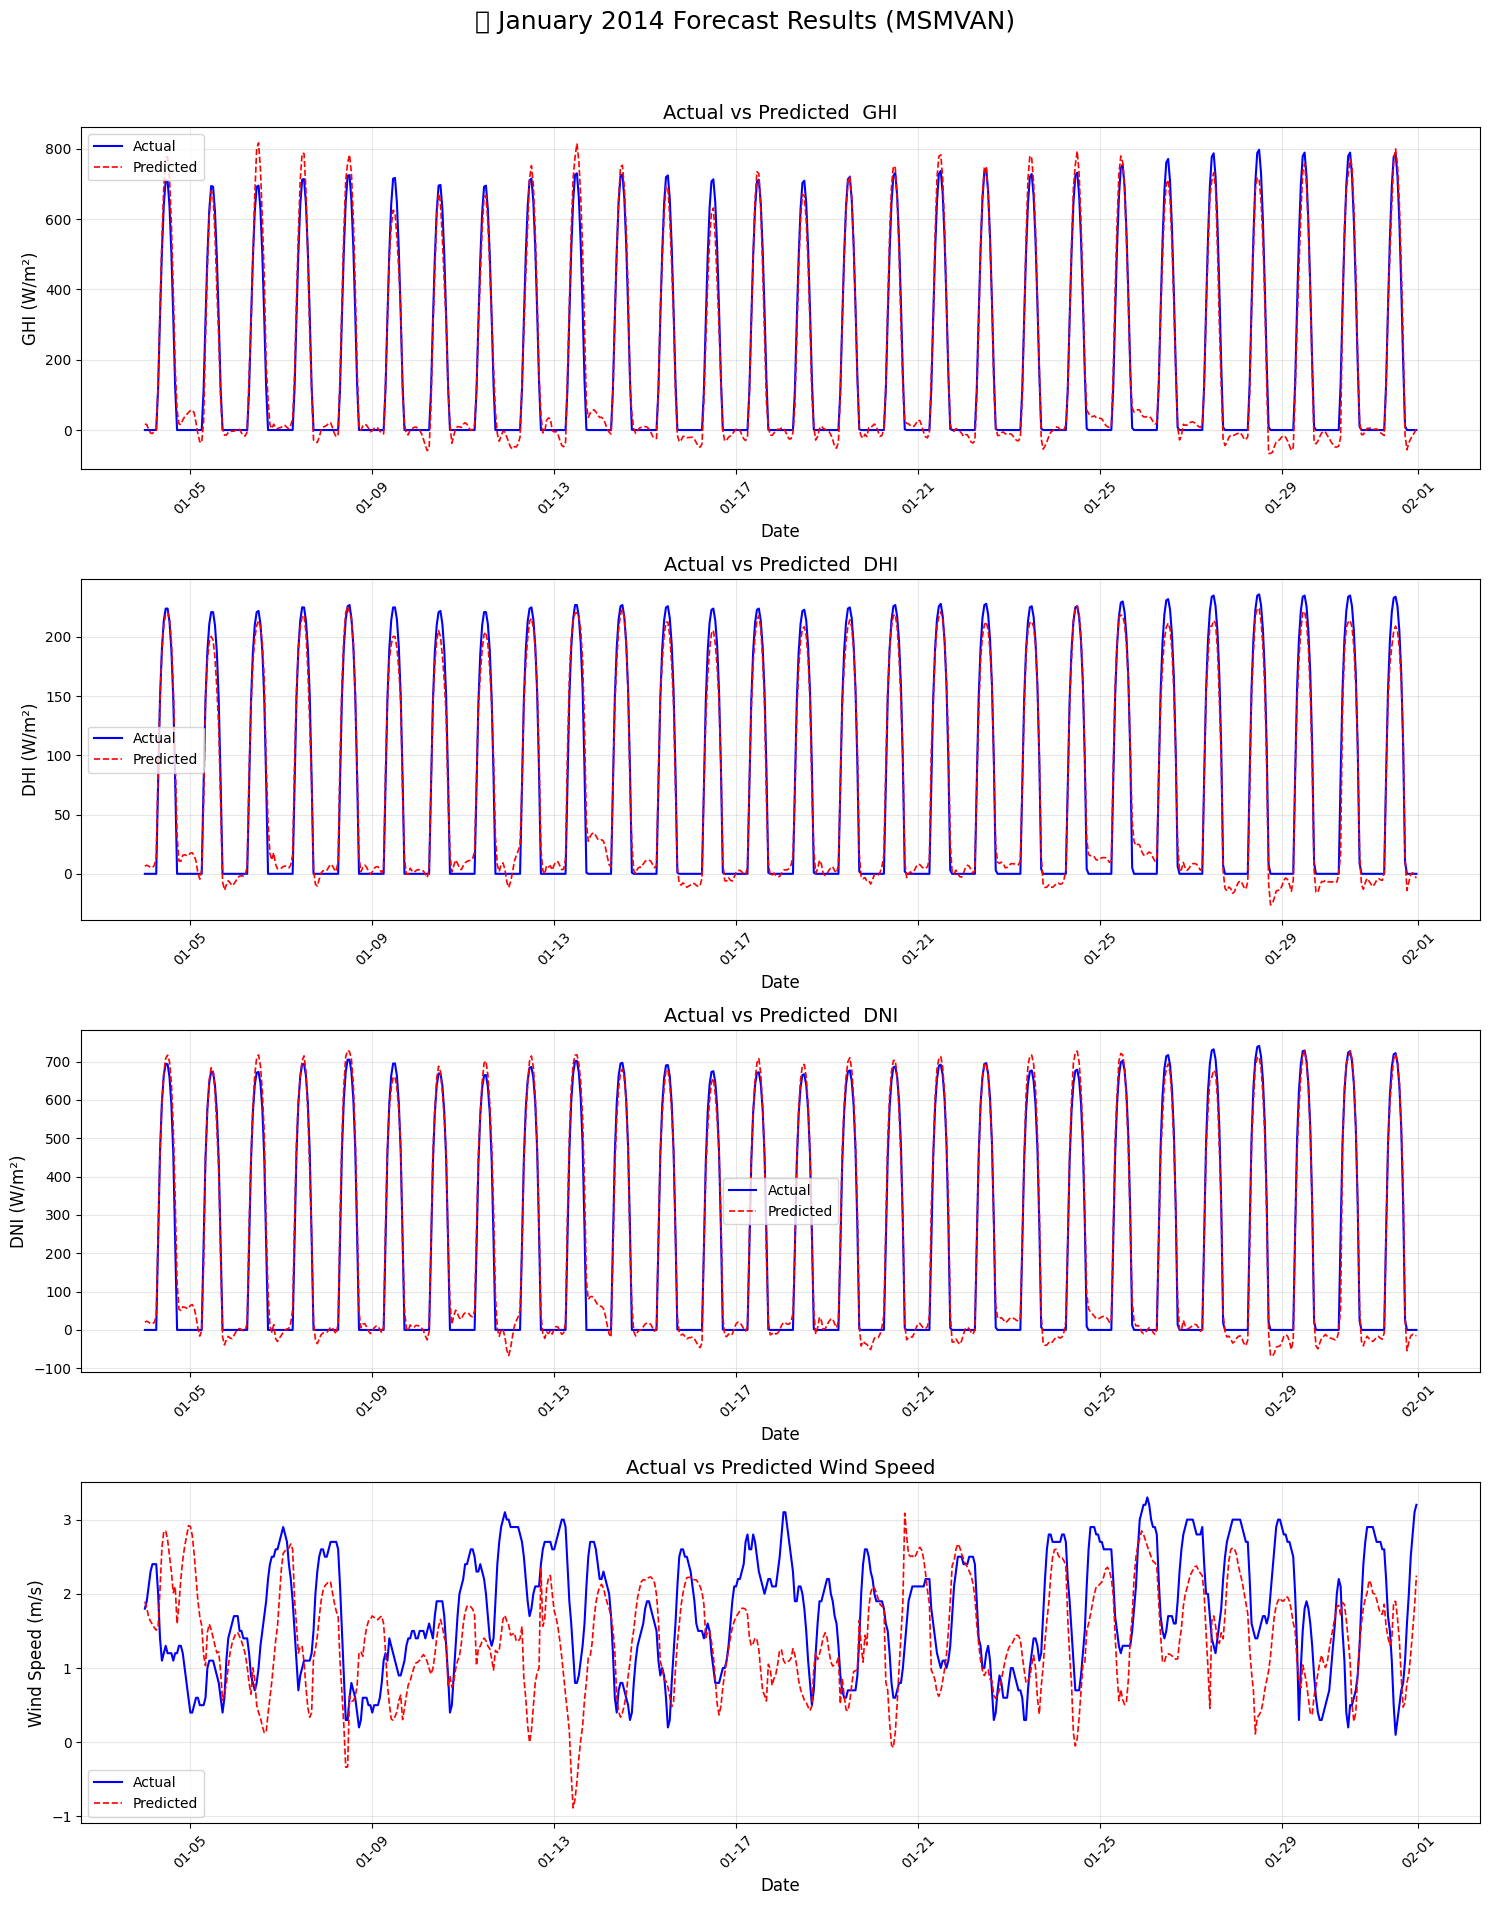

✅ Plot saved as: msmvan_forecast_plot.png
✅ Model saved as: msmvan_forecast_model.pth

✅ MSMVAN Implementation Completed Successfully!


In [4]:
#MSMVAN

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from google.colab import files
import time
import math

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Upload CSV files
print("Please upload your 2013.csv file:")
uploaded_2013 = files.upload()
print("\nPlease upload your 2014.csv file:")
uploaded_2014 = files.upload()

# Get file names
file_2013 = list(uploaded_2013.keys())[0]
file_2014 = list(uploaded_2014.keys())[0]

print(f"\nUsing files: {file_2013} and {file_2014}")

# Load datasets
def load_datasets(file_2013, file_2014):
    df_2013 = pd.read_csv(file_2013, skiprows=2)
    df_2014 = pd.read_csv(file_2014, skiprows=2)

    # Filter January 2014 data
    df_jan2014 = df_2014[(df_2014['Year'] == 2014) & (df_2014['Month'] == 1)]

    return df_2013, df_jan2014

# Load data
df_2013, df_jan2014 = load_datasets(file_2013, file_2014)

# Data Preprocessing
def preprocess_data(df_2013, df_jan2014):
    # Select relevant columns
    target_cols = ['Clearsky GHI', 'Clearsky DHI', 'Clearsky DNI', 'Wind Speed']

    # Find common columns between the datasets
    common_cols = list(set(df_2013.columns) & set(df_jan2014.columns))
    feature_cols = [col for col in common_cols if col not in target_cols + ['Year', 'Month', 'Day', 'Hour']]

    print(f"Using features: {feature_cols}")
    print(f"Targets: {target_cols}")

    # Create datetime index
    df_2013['Datetime'] = pd.to_datetime(df_2013[['Year', 'Month', 'Day', 'Hour']])
    df_jan2014['Datetime'] = pd.to_datetime(df_jan2014[['Year', 'Month', 'Day', 'Hour']])

    # Set datetime index
    df_2013 = df_2013.set_index('Datetime')
    df_jan2014 = df_jan2014.set_index('Datetime')

    # Extract features and targets
    X_2013 = df_2013[feature_cols].values
    y_2013 = df_2013[target_cols].values

    X_jan2014 = df_jan2014[feature_cols].values
    y_jan2014 = df_jan2014[target_cols].values

    # Normalize data
    x_scaler = StandardScaler()
    X_2013 = x_scaler.fit_transform(X_2013)
    X_jan2014 = x_scaler.transform(X_jan2014)

    y_scaler = StandardScaler()
    y_2013 = y_scaler.fit_transform(y_2013)

    return X_2013, y_2013, X_jan2014, y_jan2014, y_scaler, df_jan2014, feature_cols, target_cols

# Preprocess data
X_2013, y_2013, X_jan2014, y_jan2014, y_scaler, df_jan2014, feature_cols, target_cols = preprocess_data(df_2013, df_jan2014)

# ========================================
# 6. Sequence Generator
# ========================================
def create_sequences(X, y, window_size=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

# ========================================
# 7. MSMVAN Architecture (as described in the paper)
# ========================================
class FourierBlock(nn.Module):
    def __init__(self, in_channels, modes):
        super().__init__()
        self.modes = modes
        # Initialize weights for Fourier transformations
        self.W_real = nn.Parameter(torch.randn(modes, in_channels))
        self.W_imag = nn.Parameter(torch.randn(modes, in_channels))
        nn.init.xavier_uniform_(self.W_real)
        nn.init.xavier_uniform_(self.W_imag)

    def forward(self, x):
        batch, seq, channels = x.shape
        # Apply Real FFT
        x_fft = torch.fft.rfft(x, dim=1)

        # Truncate to specified modes
        x_fft_modes = x_fft[:, :self.modes, :]

        # Create complex weights
        W = torch.complex(self.W_real, self.W_imag)

        # Apply weights in frequency domain
        out_fft = x_fft_modes * W.unsqueeze(0)

        # Pad with zeros for inverse transform
        out_fft_full = torch.zeros(batch, seq//2+1, channels,
                                  dtype=torch.cfloat, device=x.device)
        out_fft_full[:, :self.modes] = out_fft

        # Inverse FFT to get back to time domain
        out = torch.fft.irfft(out_fft_full, n=seq, dim=1)
        return out

class MSMVAN(nn.Module):
    def __init__(self, c_in, c_out, hidden_size, modes, kernel_size=3, dilation=1):
        super().__init__()
        # BiLSTM layer for bidirectional sequence processing
        self.bilstm = nn.LSTM(c_in, hidden_size, batch_first=True, bidirectional=True)

        # Local convolution branch
        self.conv_local = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size,
            padding=(kernel_size-1)//2,
            dilation=dilation
        )

        # Fourier block for global patterns
        self.fourier_block = FourierBlock(hidden_size, modes)

        # Attention mechanism
        self.attn_layer = nn.Linear(2 * hidden_size, 1)

        # Output layer
        self.fc_out = nn.Linear(2 * hidden_size, c_out)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'conv' in name or 'fc' in name:
                    nn.init.xavier_uniform_(param)
                elif 'lstm' in name:
                    for i in range(0, param.shape[0], 4):
                        nn.init.xavier_uniform_(param[i:i+2])
                        nn.init.orthogonal_(param[i+2:i+4])

    def forward(self, x):
        # BiLSTM processing
        lstm_out, _ = self.bilstm(x)

        # Split BiLSTM output into two branches
        local_in, global_in = torch.split(lstm_out, lstm_out.size(2)//2, dim=2)

        # Local branch: 1D convolution
        local_in_perm = local_in.permute(0, 2, 1)
        local_out = self.conv_local(local_in_perm).permute(0, 2, 1)

        # Global branch: Fourier transformations
        global_out = self.fourier_block(global_in)

        # Combine local and global features
        combined = torch.cat([local_out, global_out], dim=2)

        # Attention mechanism
        attn_weights = self.attn_layer(combined)
        attn_weights = F.relu(attn_weights).squeeze(2)
        attn_weights = F.softmax(attn_weights, dim=1).unsqueeze(1)

        # Context vector via attention
        context = torch.bmm(attn_weights, combined).squeeze(1)

        # Final output
        output = self.fc_out(context)
        return output

# ========================================
# Fixed Hyperparameters Configuration
# ========================================
fixed_config = {
    "window_size": 72,
    "hidden_size": 32,  # BiLSTM hidden size
    "modes": 16,        # Fourier modes
    "dilation": 1,
    "kernel_size": 3,
    "batch_size": 32,
    "lr": 0.0005,
    "epochs": 200,
}

# === Train Final Model ===
def train_final_model(config):
    window = config["window_size"]
    X_seq, y_seq = create_sequences(X_2013, y_2013, window)

    # Create validation split (10%)
    split_idx = int(0.9 * len(X_seq))
    X_train, X_val = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_val = y_seq[:split_idx], y_seq[split_idx:]

    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)),
        batch_size=config["batch_size"],
        shuffle=True
    )

    val_loader = DataLoader(
        TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)),
        batch_size=config["batch_size"],
        shuffle=False
    )

    model = MSMVAN(
        c_in=X_seq.shape[2],
        c_out=y_seq.shape[1],
        hidden_size=config["hidden_size"],
        modes=config["modes"],
        kernel_size=config["kernel_size"],
        dilation=config["dilation"]
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    criterion = nn.MSELoss()

    # For tracking best model
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []

    for epoch in range(config["epochs"]):
        model.train()
        total_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_loss = criterion(model(xb), yb)
                total_val_loss += val_loss.item() * xb.size(0)

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()

        print(f"Epoch {epoch+1}/{config['epochs']} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # Load best model state
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

# === Evaluate on January 2014 ===
def evaluate_model(model, config):
    window = config["window_size"]
    X_jan_seq, y_jan_seq = create_sequences(X_jan2014, y_jan2014, window)
    X_jan_t = torch.tensor(X_jan_seq, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_jan_t).cpu().numpy()

    # Inverse scale predictions
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    actual = y_jan2014[window:]

    # Metrics
    mse = mean_squared_error(actual, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, y_pred, multioutput='raw_values')

    metrics = pd.DataFrame({
        'Metric': ['MSE', 'RMSE', 'MAE'],
        'GHI': [mse[0], rmse[0], mae[0]],
        'DHI': [mse[1], rmse[1], mae[1]],
        'DNI': [mse[2], rmse[2], mae[2]],
        'Wind Speed': [mse[3], rmse[3], mae[3]]
    })

    print("\n📊 Final Evaluation Metrics for January 2014 (MSMVAN):")
    print(metrics)

    return actual, y_pred, metrics

# === Save Results ===
def save_results(df_jan2014, actual, y_pred, config):
    window = config["window_size"]
    results_df = pd.DataFrame({
        'Datetime': df_jan2014.index[window:],
        'Actual_GHI': actual[:, 0],
        'Predicted_GHI': y_pred[:, 0],
        'Actual_DHI': actual[:, 1],
        'Predicted_DHI': y_pred[:, 1],
        'Actual_DNI': actual[:, 2],
        'Predicted_DNI': y_pred[:, 2],
        'Actual_Wind_Speed': actual[:, 3],
        'Predicted_Wind_Speed': y_pred[:, 3]
    })

    results_df.to_csv("january_2014_forecast_results_MSMVAN.csv", index=False)
    print("✅ Results saved to: january_2014_forecast_results_MSMVAN.csv")
    return results_df

# === Plot Actual vs Predicted ===
def plot_results(results_df):
    target_cols = ['GHI', 'DHI', 'DNI', 'Wind Speed']
    fig, axes = plt.subplots(4, 1, figsize=(15, 20))
    fig.suptitle('📈 January 2014 Forecast Results (MSMVAN)', fontsize=18)

    # Define titles and units
    titles = [
        'Actual vs Predicted  GHI',
        'Actual vs Predicted  DHI',
        'Actual vs Predicted  DNI',
        'Actual vs Predicted Wind Speed'
    ]
    units = ['GHI (W/m²)', 'DHI (W/m²)', 'DNI (W/m²)', 'Wind Speed (m/s)']

    # Create date formatter
    xfmt = mdates.DateFormatter('%m-%d')

    for i, col in enumerate(target_cols):
        col_key = col.replace(" ", "_")

        # Plot both actual and predicted
        axes[i].plot(results_df['Datetime'], results_df[f'Actual_{col_key}'],
                     'b-', label='Actual', linewidth=1.5)
        axes[i].plot(results_df['Datetime'], results_df[f'Predicted_{col_key}'],
                     'r--', label='Predicted', linewidth=1.2)

        axes[i].set_title(titles[i], fontsize=14)
        axes[i].set_ylabel(units[i], fontsize=12)
        axes[i].set_xlabel('Date', fontsize=12)
        axes[i].legend(fontsize=10)
        axes[i].grid(True, alpha=0.3)

        # Apply date formatting
        axes[i].xaxis.set_major_formatter(xfmt)
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig("msmvan_forecast_plot.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Plot saved as: msmvan_forecast_plot.png")

# === Training History Plot ===
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.title('Model Training History', fontsize=16)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.savefig('msmvan_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Training history plot saved")

# === Save Model ===
def save_model(model):
    torch.save(model.state_dict(), "msmvan_forecast_model.pth")
    print("✅ Model saved as: msmvan_forecast_model.pth")

# ========================================
# Main Execution
# ========================================
if __name__ == "__main__":
    print("\n" + "="*50)
    print("🚀 Starting MSMVAN Model Training")
    print("="*50)
    print(f"Window Size: {fixed_config['window_size']}")
    print(f"Hidden Size: {fixed_config['hidden_size']}")
    print(f"Fourier Modes: {fixed_config['modes']}")
    print(f"Dilation: {fixed_config['dilation']}")
    print(f"Kernel Size: {fixed_config['kernel_size']}")
    print(f"Batch Size: {fixed_config['batch_size']}")
    print(f"Learning Rate: {fixed_config['lr']}")
    print(f"Epochs: {fixed_config['epochs']}")

    # Train model
    model, train_losses, val_losses = train_final_model(fixed_config)

    # Plot training history
    plot_training_history(train_losses, val_losses)

    # Evaluate and save results
    actual, y_pred, metrics = evaluate_model(model, fixed_config)
    results_df = save_results(df_jan2014, actual, y_pred, fixed_config)

    # Plot results
    plot_results(results_df)

    # Save model
    save_model(model)

    print("\n" + "="*50)
    print("✅ MSMVAN Implementation Completed Successfully!")
    print("="*50)

✅ Successfully loaded all result files.


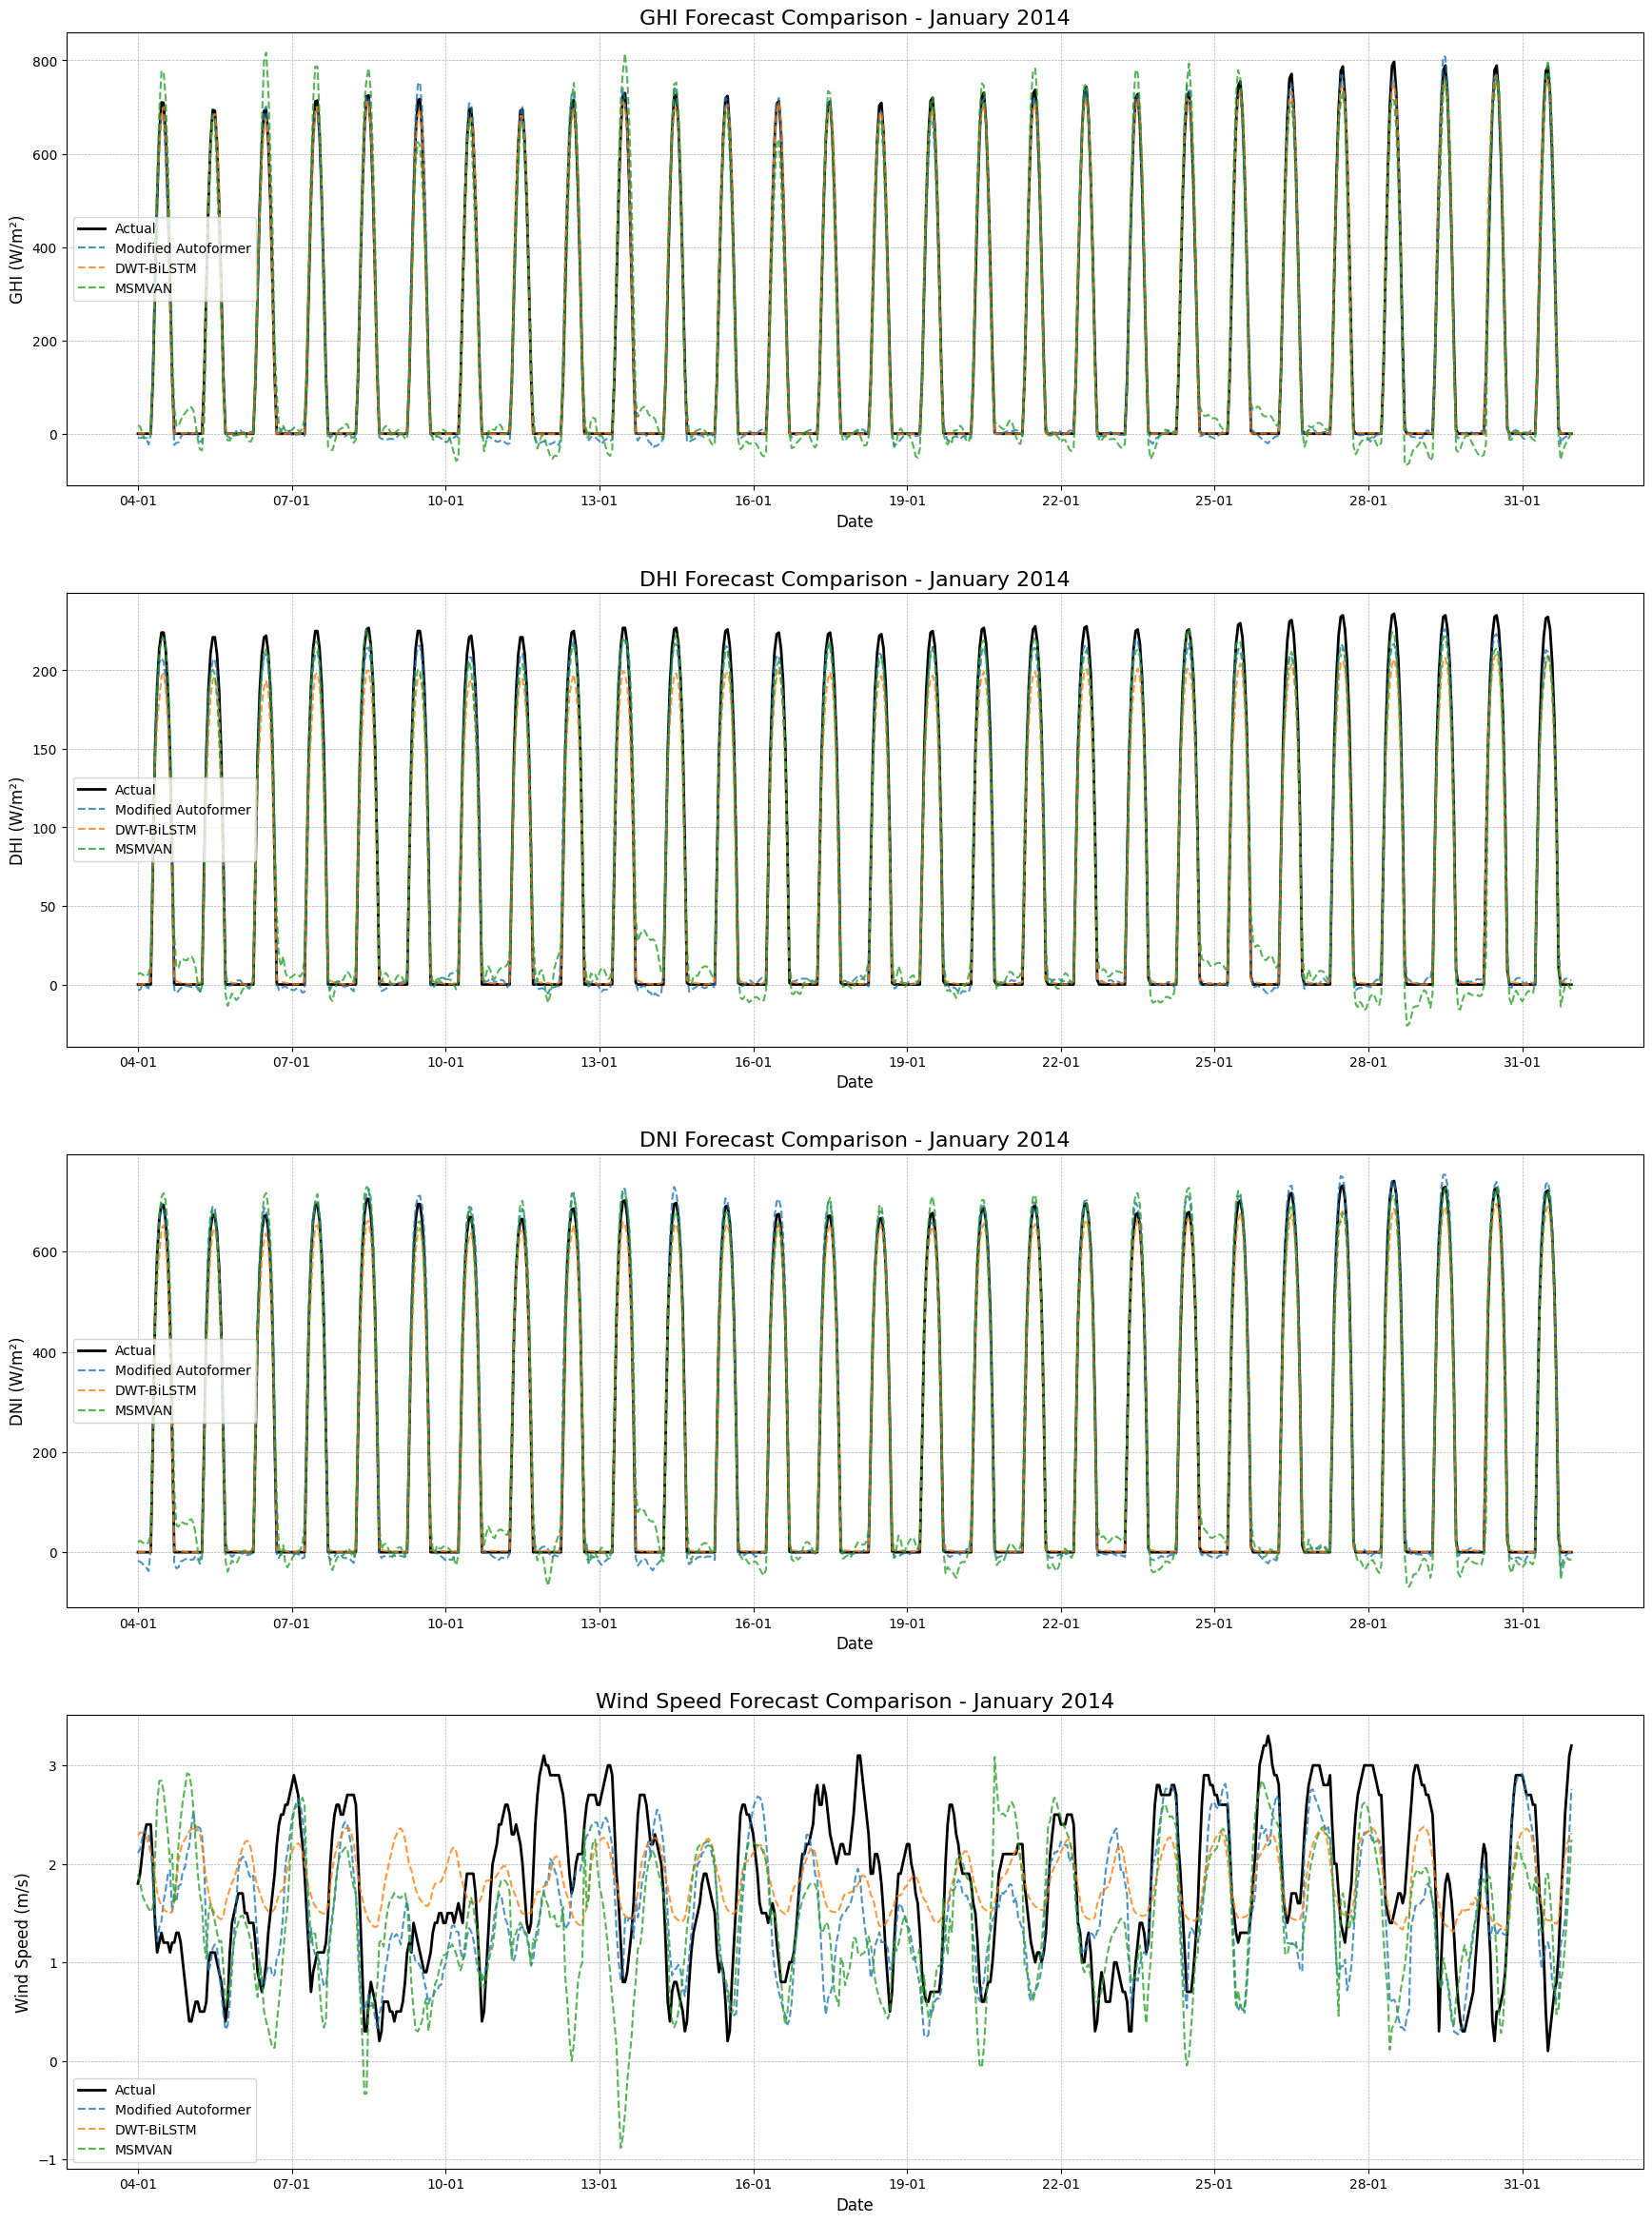

✅ Comparative plot saved as: comparative_forecast_plot.png

📊 Comparative Evaluation Metrics

Mean Squared Error (MSE):
Model       DWT-BiLSTM     MSMVAN  Modified Autoformer
Target                                                
DHI           200.6382   153.3207              52.1331
DNI           463.6408  1026.7319             361.2941
GHI           307.8773  1463.7174             236.8676
Wind Speed      0.4687     0.6576               0.4496

Root Mean Squared Error (RMSE):
Model       DWT-BiLSTM   MSMVAN  Modified Autoformer
Target                                              
DHI            14.1647  12.3823               7.2203
DNI            21.5323  32.0427              19.0077
GHI            17.5464  38.2586              15.3905
Wind Speed      0.6846   0.8109               0.6705

Mean Absolute Error (MAE):
Model       DWT-BiLSTM   MSMVAN  Modified Autoformer
Target                                              
DHI             9.0948   9.7507               5.1868
DNI         

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# ========================================
# Load the Results from CSV Files
# ========================================

try:
    df_autoformer = pd.read_csv('january_2014_forecast_results_modified_autoformer.csv')
    df_dwt_bilstm = pd.read_csv('january_2014_forecast_results_dwt_bilstm.csv')
    df_msmvan = pd.read_csv('january_2014_forecast_results_MSMVAN.csv')

    # Convert 'Datetime' column to datetime objects
    df_autoformer['Datetime'] = pd.to_datetime(df_autoformer['Datetime'])
    df_dwt_bilstm['Datetime'] = pd.to_datetime(df_dwt_bilstm['Datetime'])
    df_msmvan['Datetime'] = pd.to_datetime(df_msmvan['Datetime'])

    print("✅ Successfully loaded all result files.")

except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure all three CSV files are in the same directory.")
    # Exit if files are not found
    exit()


# ========================================
# Modified Comparative Plotting
# ========================================

def plot_comparative_results(df_autoformer, df_dwt_bilstm, df_msmvan):
    target_cols = ['GHI', 'DHI', 'DNI', 'Wind_Speed']
    target_labels = ['GHI (W/m²)', 'DHI (W/m²)', 'DNI (W/m²)', 'Wind Speed (m/s)']

    # Set sharex=False so each subplot can have its own x-axis labels
    fig, axes = plt.subplots(len(target_cols), 1, figsize=(18, 24))

    for i, (col, label) in enumerate(zip(target_cols, target_labels)):
        # Plot the actual values (they are the same across all dataframes)
        axes[i].plot(df_autoformer['Datetime'], df_autoformer[f'Actual_{col}'], label='Actual', color='black', linewidth=2)

        # Plot predictions from each model
        axes[i].plot(df_autoformer['Datetime'], df_autoformer[f'Predicted_{col}'], label='Modified Autoformer', linestyle='--', alpha=0.8)
        axes[i].plot(df_dwt_bilstm['Datetime'], df_dwt_bilstm[f'Predicted_{col}'], label='DWT-BiLSTM', linestyle='--', alpha=0.8)
        axes[i].plot(df_msmvan['Datetime'], df_msmvan[f'Predicted_{col}'], label='MSMVAN', linestyle='--', alpha=0.8)

        axes[i].set_ylabel(label, fontsize=12)

        # Set the specific title format as requested
        title_col_name = col.replace("_", " ")
        axes[i].set_title(f'{title_col_name} Forecast Comparison - January 2014', fontsize=16)

        axes[i].legend()
        axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)

        # Set the x-axis label for every plot
        axes[i].set_xlabel('Date', fontsize=12)

        # --- Apply date formatting to EACH subplot ---
        # Set a tick locator to space out the dates every 3 days
        axes[i].xaxis.set_major_locator(mdates.DayLocator(interval=3))
        # Set the formatter to show Day-Month
        xfmt = mdates.DateFormatter('%d-%m')
        axes[i].xaxis.set_major_formatter(xfmt)

        # Set the rotation of the x-tick labels for readability
        # This is applied to each subplot's x-axis
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(0)
            tick.set_ha('center')

    # Adjust layout to prevent titles and labels from overlapping
    plt.tight_layout(pad=3.0)
    plt.savefig("comparative_forecast_plot.png", dpi=300)
    plt.show()
    print("✅ Comparative plot saved as: comparative_forecast_plot.png")

plot_comparative_results(df_autoformer, df_dwt_bilstm, df_msmvan)


# ========================================
# Comparative Results Table
# ========================================

def calculate_metrics(df, model_name):
    metrics = {}
    target_cols = ['GHI', 'DHI', 'DNI', 'Wind_Speed']
    for col in target_cols:
        actual = df[f'Actual_{col}']
        predicted = df[f'Predicted_{col}']
        mse = np.mean((actual - predicted)**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(actual - predicted))
        metrics[col] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae}
    return metrics

# Calculate metrics for each model
metrics_autoformer = calculate_metrics(df_autoformer, 'Modified Autoformer')
metrics_dwt_bilstm = calculate_metrics(df_dwt_bilstm, 'DWT-BiLSTM')
metrics_msmvan = calculate_metrics(df_msmvan, 'MSMVAN')

# Create a summary DataFrame
summary_data = []
models = {
    'Modified Autoformer': metrics_autoformer,
    'DWT-BiLSTM': metrics_dwt_bilstm,
    'MSMVAN': metrics_msmvan
}

for model_name, metrics in models.items():
    for target, values in metrics.items():
        summary_data.append({
            'Model': model_name,
            'Target': target.replace('_', ' '),
            'MSE': values['MSE'],
            'RMSE': values['RMSE'],
            'MAE': values['MAE']
        })

df_summary = pd.DataFrame(summary_data)

# Pivot the table for better readability
df_pivot_mse = df_summary.pivot(index='Target', columns='Model', values='MSE')
df_pivot_rmse = df_summary.pivot(index='Target', columns='Model', values='RMSE')
df_pivot_mae = df_summary.pivot(index='Target', columns='Model', values='MAE')

print("\n" + "="*80)
print("📊 Comparative Evaluation Metrics")
print("="*80)

print("\nMean Squared Error (MSE):")
print(df_pivot_mse.round(4))

print("\nRoot Mean Squared Error (RMSE):")
print(df_pivot_rmse.round(4))

print("\nMean Absolute Error (MAE):")
print(df_pivot_mae.round(4))

print("\n" + "="*80)

# Save the summary to a CSV file
df_summary.to_csv('comparative_metrics_summary.csv', index=False)
print("✅ Comparative metrics summary saved to: comparative_metrics_summary.csv")